In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import MinMaxScaler
import gower
from utility import *
import warnings

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('bank-full.csv', sep = ';')

# Segmentation and Rule Based Decisioning Approach
    - Could we understand the audience better? 
    - What groups of audience are there? 
    - What are some characteristics of each group?

The K-means algorithm is well known for its efficiency in clustering large data sets. However, one of the drawback of this algorithm is that it only works with numeric data because the algorithm minimises a cost function by changing the means of clusters (usually) using euclidian distance. When categorical variables are involved in the dataset, this dis/similarity measure does not necessarily produce meaningful results unless they are ordinal variables. 

## K-Medoids with Gower Distance

In [3]:
seg_data = data[(data['job'] != 'unknown') & (data['marital'] != 'unknown') & (data['education'] != 'unknown')]

orig_idx = seg_data.index # store index for later profiling exercise

seg_cols = ['age','balance','job','marital','education'] 
seg_data = seg_data[seg_cols]

# Normalize
scaler = MinMaxScaler()
seg_data[['age','balance']] = scaler.fit_transform((seg_data[['age', 'balance']]))

cat_var = [True] * len(seg_data.columns)
cat_var[0:2] = [False,False]

model_data = np.asarray(seg_data)

gower_dist = gower.gower_matrix(model_data, cat_features = cat_var)

In [4]:
medoids_kmedoids = []
labels_kmedoids = []
sklearn_scores_kmedoids = []

for k in range(2,10):
    kmedoids = KMedoids(n_clusters = k, metric = 'precomputed', random_state = 0).fit(gower_dist)
    
    labels_kmedoids.append(kmedoids.labels_)
    medoids_kmedoids.append(kmedoids.cluster_centers_)
    
    sklearn_scores_kmedoids.append(silhouette_score(X = gower_dist, labels = kmedoids.labels_, metric = 'precomputed'))

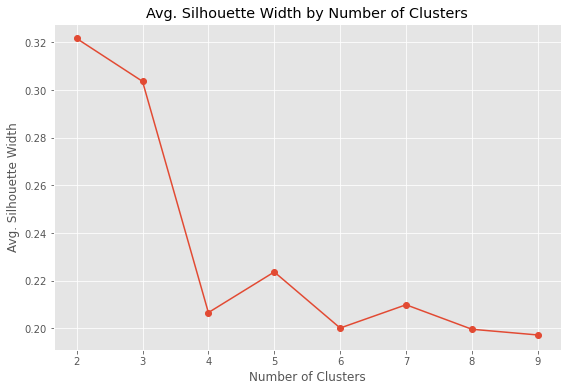

In [5]:
f, ax = plt.subplots(figsize = (20,6))

plt.subplot(121)
plt.plot(sklearn_scores_kmedoids, marker = 'o', label = 'Number of Clusters')
plt.title('Avg. Silhouette Width by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Avg. Silhouette Width')
plt.xticks(np.arange(0,8), np.arange(2, 10))
plt.show()

In [11]:
from scipy.optimize import minimize

def objective_func(weights):
    gower_dist = gower.gower_matrix(model_data, cat_features = cat_var, weight = weights)
    kmedoids = KMedoids(n_clusters = 3, metric = 'precomputed', random_state = 0).fit(gower_dist)
    avg_sil_score = silhouette_score(X = gower_dist, labels = kmedoids.labels_, metric = 'precomputed')

    return -avg_sil_score

def constraint1(weights):
    max = 3 ** len(weights)
    prod = 1
    for i in range(len(weights)):
        prod *= i 
    return 81 - prod
 
init_weights = [1.0,1.0,1.0,1.0,1.0]
boundary = [(1.0, 3.0)] * len(init_weights)

sol = minimize(fun = objective_func, x0 = init_weights, method = 'SLSQP', bounds = boundary)

In [16]:
print(sol)

     fun: -0.30363529920578003
     jac: array([0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([1., 1., 1., 1., 1.])


In [17]:
gower_dist = gower.gower_matrix(model_data, cat_features = cat_var, weight = sol.x)#np.array([0.38582215, 0.38582215,1.0,1.0,1.0]))

kmedoids = KMedoids(n_clusters = 3, metric = 'precomputed', random_state = 0).fit(gower_dist)

k_med_segments = pd.Series(kmedoids.labels_.tolist(), name = 'segment')
k_med_data_with_seg = pd.concat([data.iloc[orig_idx,:].reset_index(drop = True), k_med_segments], axis = 1)
k_med_data_with_seg['segment'] = k_med_data_with_seg['segment'].apply(lambda x: 'Segment ' + str(x+1))

In [18]:
side_by_side_profile(k_med_data_with_seg, 'segment', False)

Segment 1 Segment 2 Segment 3
               Volume                 19396     11336     12461
               Avg. Age                  45      33.5      40.7
Marital Status divorced              11.63%    11.09%    12.17%
               married               86.42%     10.6%    64.06%
               single                 1.95%    78.31%    23.78%
Education      primary               27.44%     6.19%     6.23%
               secondary             72.38%    77.38%     2.58%
               tertiary               0.19%    16.43%     91.2%
Occupation     admin.                14.14%    16.23%     3.35%
               blue-collar           39.72%    13.33%     0.51%
               entrepreneur           2.88%      1.7%     5.29%
               housemaid              3.95%     1.25%      2.3%
               management             2.54%     2.74%    67.51%
               retired                8.71%     0.68%     3.04%
               self-employed          2.71%     3.14%     5.29%
               services              12.74%    11.55%      1.8%
               student                 0.1%     6.33%      0.3%
               technician             9.22%    39.83%     8.44%
               unemployed             3.29%     3.21%     2.18%
               housing               59.79%    57.89%    49.23%
               default                 1.8%     2.03%     1.63%
               loan                  18.75%    15.28%    13.96%
               Median Balance ($)    $425.0    $367.0    $567.0

In [19]:
resp_by_segment = k_med_data_with_seg.pivot_table(index = 'segment', columns = 'y', aggfunc='size')
resp_by_segment['total'] = resp_by_segment.sum(axis = 1)
resp_by_segment['resp_rate'] = round(resp_by_segment.apply(lambda x: x['yes']/x['total'], axis = 1),4)

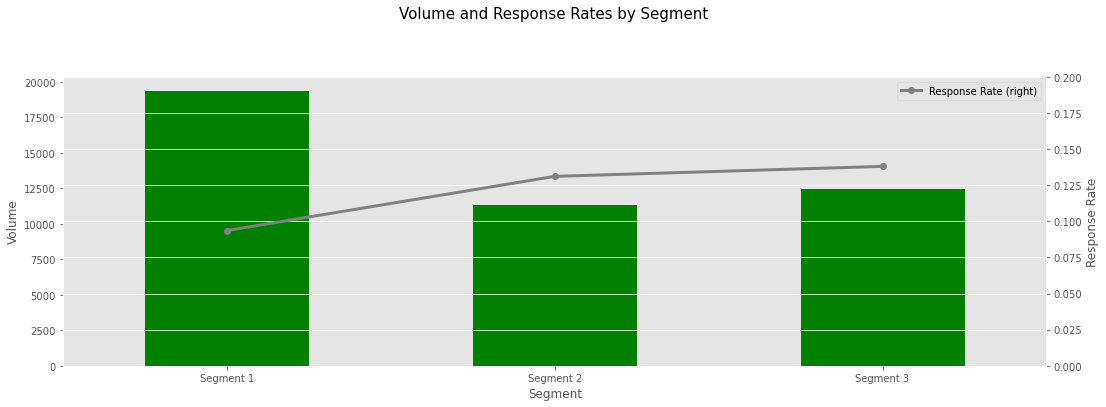

In [20]:
f, ax = plt.subplots(figsize = (16,6))
ax2 = ax.twinx()
volume_plot = resp_by_segment.plot(y = 'total', kind = 'bar', ax = ax, legend = False, color = ['green'], rot = 360)
resp_plot = resp_by_segment.plot(y = 'resp_rate', kind = 'line', color = 'grey', lw = 3, marker = 'o',
                                 label = 'Response Rate', secondary_y = True, ax = ax2)

plt.suptitle('Volume and Response Rates by Segment', fontsize = 15)
volume_plot.set_ylabel('Volume')
volume_plot.set_xlabel('Segment')
resp_plot.set_ylabel('Response Rate')
resp_plot.set_ybound(0, 0.2)

ax.grid(b = None)
plt.tight_layout(pad = 3)
plt.show()

## Responder vs. Non Responder by Segment

In [21]:
resp_seg = k_med_data_with_seg[k_med_data_with_seg['y'] == 'yes']
non_resp_seg = k_med_data_with_seg[k_med_data_with_seg['y'] == 'no']

resp_seg_profile = side_by_side_profile(resp_seg, 'segment', overall = False)
non_resp_seg_profile = side_by_side_profile(non_resp_seg, 'segment', overall = False)

print("Responder Profile (Left) vs. Non Responder Profile (Right)")
display_side_by_side(resp_seg_profile, non_resp_seg_profile)

Responder Profile (Left) vs. Non Responder Profile (Right)


Segment 1 
 Segment 2 
 Segment 3 
 
 
 
 
 
 Volume 
 1815 
 1486 
 1720 
 
 
 Avg. Age 
 49.5 
 31.9 
 41.3 
 
 
 Marital Status 
 divorced 
 15.54% 
 7.6% 
 11.8% 
 
 
 married 
 82.42% 
 7.47% 
 57.91% 
 
 
 single 
 2.04% 
 84.93% 
 30.29% 
 
 
 Education 
 primary 
 24.85% 
 5.38% 
 3.31% 
 
 
 secondary 
 75.04% 
 70.52% 
 1.8% 
 
 
 tertiary 
 0.11% 
 24.09% 
 94.88% 
 
 
 Occupation 
 admin. 
 16.53% 
 16.49% 
 3.95% 
 
 
 blue-collar 
 27.66% 
 11.1% 
 0.47% 
 
 
 entrepreneur 
 2.37% 
 1.62% 
 2.85% 
 
 
 housemaid 
 3.31% 
 1.62% 
 1.22% 
 
 
 management 
 2.42% 
 1.55% 
 68.95% 
 
 
 retired 
 20.72% 
 0.47% 
 5.99% 
 
 
 self-employed 
 1.93% 
 4.64% 
 4.53% 
 
 
 services 
 10.3% 
 9.76% 
 1.05% 
 
 
 student 
 0.28% 
 14.33% 
 0.47% 
 
 
 technician 
 9.53% 
 34.05% 
 8.02% 
 
 
 unemployed 
 4.96% 
 4.37% 
 2.5% 
 
 
 
 housing 
 40.22% 
 40.11% 
 31.86% 
 
 
 default 
 0.83% 
 1.28% 
 0.81% 
 
 
 loan 
 11.96% 
 9.22% 
 6.92% 
 
 
 Median Balance ($) 
 $802.0 
 $531.0 
 $925.5 
 
 
 
 
 
 
 
 Segment 1 
 Segment 2 
 Segment 3 
 
 
 
 
 
 Volume 
 17581 
 9850 
 10741 
 
 
 Avg. Age 
 44.6 
 33.7 
 40.7 
 
 
 Marital Status 
 divorced 
 11.22% 
 11.61% 
 12.22% 
 
 
 married 
 86.83% 
 11.08% 
 65.04% 
 
 
 single 
 1.95% 
 77.31% 
 22.74% 
 
 
 Education 
 primary 
 27.71% 
 6.31% 
 6.69% 
 
 
 secondary 
 72.1% 
 78.42% 
 2.7% 
 
 
 tertiary 
 0.19% 
 15.27% 
 90.61% 
 
 
 Occupation 
 admin. 
 13.89% 
 16.19% 
 3.26% 
 
 
 blue-collar 
 40.96% 
 13.66% 
 0.51% 
 
 
 entrepreneur 
 2.93% 
 1.72% 
 5.68% 
 
 
 housemaid 
 4.02% 
 1.2% 
 2.47% 
 
 
 management 
 2.55% 
 2.92% 
 67.27% 
 
 
 retired 
 7.47% 
 0.71% 
 2.57% 
 
 
 self-employed 
 2.79% 
 2.91% 
 5.41% 
 
 
 services 
 12.99% 
 11.82% 
 1.92% 
 
 
 student 
 0.09% 
 5.13% 
 0.27% 
 
 
 technician 
 9.19% 
 40.7% 
 8.51% 
 
 
 unemployed 
 3.12% 
 3.04% 
 2.13% 
 
 
 
 housing 
 61.81% 
 60.57% 
 52.01% 
 
 
 default 
 1.9% 
 2.14% 
 1.76% 
 
 
 loan 
 19.45% 
 16.19% 
 15.08% 
 
 
 Median Balance ($) 
 $399.0 
 $341.0 
 $528.0

In [22]:
segment1 = k_med_data_with_seg[k_med_data_with_seg['segment'] == 'Segment 1']
segment2 = k_med_data_with_seg[k_med_data_with_seg['segment'] == 'Segment 2']
segment3 = k_med_data_with_seg[k_med_data_with_seg['segment'] == 'Segment 3']

display_side_by_side(side_by_side_profile(segment1, 'y'), side_by_side_profile(segment2, 'y'), 
                     side_by_side_profile(segment3, 'y'))

no 
 yes 
 
 
 
 
 
 Volume 
 17581 
 1815 
 
 
 Avg. Age 
 44.6 
 49.5 
 
 
 Marital Status 
 divorced 
 11.22% 
 15.54% 
 
 
 married 
 86.83% 
 82.42% 
 
 
 single 
 1.95% 
 2.04% 
 
 
 Education 
 primary 
 27.71% 
 24.85% 
 
 
 secondary 
 72.1% 
 75.04% 
 
 
 tertiary 
 0.19% 
 0.11% 
 
 
 Occupation 
 admin. 
 13.89% 
 16.53% 
 
 
 blue-collar 
 40.96% 
 27.66% 
 
 
 entrepreneur 
 2.93% 
 2.37% 
 
 
 housemaid 
 4.02% 
 3.31% 
 
 
 management 
 2.55% 
 2.42% 
 
 
 retired 
 7.47% 
 20.72% 
 
 
 self-employed 
 2.79% 
 1.93% 
 
 
 services 
 12.99% 
 10.3% 
 
 
 student 
 0.09% 
 0.28% 
 
 
 technician 
 9.19% 
 9.53% 
 
 
 unemployed 
 3.12% 
 4.96% 
 
 
 
 housing 
 61.81% 
 40.22% 
 
 
 default 
 1.9% 
 0.83% 
 
 
 loan 
 19.45% 
 11.96% 
 
 
 Median Balance ($) 
 $399.0 
 $802.0 
 
 
 
 
 
 
 
 no 
 yes 
 
 
 
 
 
 Volume 
 9850 
 1486 
 
 
 Avg. Age 
 33.7 
 31.9 
 
 
 Marital Status 
 divorced 
 11.61% 
 7.6% 
 
 
 married 
 11.08% 
 7.47% 
 
 
 single 
 77.31% 
 84.93% 
 
 
 Education 
 primary 
 6.31% 
 5.38% 
 
 
 secondary 
 78.42% 
 70.52% 
 
 
 tertiary 
 15.27% 
 24.09% 
 
 
 Occupation 
 admin. 
 16.19% 
 16.49% 
 
 
 blue-collar 
 13.66% 
 11.1% 
 
 
 entrepreneur 
 1.72% 
 1.62% 
 
 
 housemaid 
 1.2% 
 1.62% 
 
 
 management 
 2.92% 
 1.55% 
 
 
 retired 
 0.71% 
 0.47% 
 
 
 self-employed 
 2.91% 
 4.64% 
 
 
 services 
 11.82% 
 9.76% 
 
 
 student 
 5.13% 
 14.33% 
 
 
 technician 
 40.7% 
 34.05% 
 
 
 unemployed 
 3.04% 
 4.37% 
 
 
 
 housing 
 60.57% 
 40.11% 
 
 
 default 
 2.14% 
 1.28% 
 
 
 loan 
 16.19% 
 9.22% 
 
 
 Median Balance ($) 
 $341.0 
 $531.0 
 
 
 
 
 
 
 
 no 
 yes 
 
 
 
 
 
 Volume 
 10741 
 1720 
 
 
 Avg. Age 
 40.7 
 41.3 
 
 
 Marital Status 
 divorced 
 12.22% 
 11.8% 
 
 
 married 
 65.04% 
 57.91% 
 
 
 single 
 22.74% 
 30.29% 
 
 
 Education 
 primary 
 6.69% 
 3.31% 
 
 
 secondary 
 2.7% 
 1.8% 
 
 
 tertiary 
 90.61% 
 94.88% 
 
 
 Occupation 
 admin. 
 3.26% 
 3.95% 
 
 
 blue-collar 
 0.51% 
 0.47% 
 
 
 entrepreneur 
 5.68% 
 2.85% 
 
 
 housemaid 
 2.47% 
 1.22% 
 
 
 management 
 67.27% 
 68.95% 
 
 
 retired 
 2.57% 
 5.99% 
 
 
 self-employed 
 5.41% 
 4.53% 
 
 
 services 
 1.92% 
 1.05% 
 
 
 student 
 0.27% 
 0.47% 
 
 
 technician 
 8.51% 
 8.02% 
 
 
 unemployed 
 2.13% 
 2.5% 
 
 
 
 housing 
 52.01% 
 31.86% 
 
 
 default 
 1.76% 
 0.81% 
 
 
 loan 
 15.08% 
 6.92% 
 
 
 Median Balance ($) 
 $528.0 
 $925.5

In [23]:
k_med_data_with_seg.to_csv('data_with_seg.csv', index = False)